# Gemicai tutorial 2: From data pre-processing to model evaluation
In this tutorial we'll be developing a neural network to classify the orientation of a mammography image. To get a good understanding of the Gemicai library, this tutorial describes the full process of doing so, from data pre-processing to model evaluation. The tutorial will be structured as follows:

[2.0 Preliminaries](#2.0)<br>
[2.1 Data preproccessing](#2.1)<br>
[2.2 Classifier initialization](#2.2)<br>
[2.3 Hyper parameter optimisation](#2.3)<br>
[2.4 Model evaluation](#2.4)

## 2.0 Preliminaries
<a id='2.0'></a>

In [1]:
import gemicai as gem
import torch
import torchvision.models as models

## 2.1 Data preproccessing
<a id='2.1'></a>
This part of the tutorial is dedicated to showing how you can convert a folder with raw .dcm or .dcm.gz files into a dataset python can interact efficiently with.

First, locate the Dicom files.

In [2]:

dicom_data = '/mnt/SharedStor/tutorials/Mammography/'

# Let's find out how many dicom images we have.
gem.utils.dir_info(dicom_data)


| Extension   |   Files | Size    |
|-------------+---------+---------|
| .dcm.gz     |    1061 | 5.75 GB | 



Now create the Gemicai dataset (or gemset). With objects_per_file you can specify how many images you want stored to a .gemset file, if your computer can handle it, it might be more efficient to increase this number. For now let's set it to 100. When specifiy a value for test_split, a training set and test set will automatically be created. test_split must always be between 0 and 1. When not specified, a single dataset will be created.

In [3]:

gemset_destination = '/mnt/SharedStor/tutorials/MG_gemset'

# Specify the relevant Dicom attributes you want to use.
dicom_attributes = ['Modality', 'BodyPartExamined', 'StudyDescription', 'SeriesDescription']


gem.dicom_to_gemset(data_origin=dicom_data, data_destination=gemset_destination, relevant_labels=dicom_attributes, 
                    objects_per_file=100, test_split=0.2, verbosity=1)


Creating .gemset took 00:03:04


Now lets inspect the created gemsets. As you can see, they take up a lot less space compared to the original Dicom files, (5.25GB -> 31.6MB) this matters espicially when training with large datasets. For the sake of the tutorial, lets only focus on correctly classifying the image orientation, which is usually stored in the SeriesDescription field. DicomoDataset.summarize() prints a table with all classes and their frequency.

By setting test_split to 0.2, a train and test set were automatically created. 

In [4]:

gem.utils.dir_info(gemset_destination)

total_dataset = gem.DicomoDataset.get_dicomo_dataset(gemset_destination, labels=dicom_attributes)
total_dataset.summarize('SeriesDescription')

# You can summarize the dataset on any Dicom attributes specified in dicom_attributes when creating the gemset
# As all images in this dataset are Mammography images, the Modality field will always be MG
total_dataset.summarize('Modality')


| Extension   |   Files | Size    |
|-------------+---------+---------|
| .gemset     |      11 | 31.6 MB | 

| Class (SeriesDescription)          |   Frequency |
|------------------------------------+-------------|
| R MLO                              |         227 |
| R CC                               |         235 |
| L CC                               |         219 |
| None                               |          57 |
| L LM                               |          12 |
| L MLO                              |         218 |
| L XCCL                             |          16 |
| L SPECIMEN                         |          12 |
| Mammografie SVOB beiderzijds       |           4 |
| R SPECIMEN                         |          12 |
| Mammopunctie stereotactisch rechts |           4 |
| R LM                               |          11 |
| R XCCL                             |          18 |
| Mammopunctie stereotactisch links  |          10 |
| R CCID                             |    

When inspecting the table, we can notice that some of these classes are low in frequency and seem out of place. To create a dataset with only the relevant classes, you can use GemicaiDataset.subset(), and pass a dictionary with constraints.

In [5]:

# These are all orientations we are interested in classifing.
orientations = ['L MLO', 'R MLO', 'L CC', 'R CC', 'L LM', 'R LM', 'L XCCL', 'R XCCL', 'L SPECIMEN', 'R SPECIMEN']

constraints = {
    'Modality': 'MG',
    'SeriesDescription': orientations,
}

subset = total_dataset.subset(constraints)

subset.summarize('SeriesDescription')


| Class (SeriesDescription)   |   Frequency |
|-----------------------------+-------------|
| R MLO                       |         227 |
| R CC                        |         235 |
| L CC                        |         219 |
| L LM                        |          12 |
| L MLO                       |         218 |
| L XCCL                      |          16 |
| L SPECIMEN                  |          12 |
| R SPECIMEN                  |          12 |
| R LM                        |          11 |
| R XCCL                      |          18 |

Total number of training images: 980 
Total number of classes: 10



Earlier when we created the new gemset, we specified a value test_split, this means automatically a train and test set are contructed. By default, they are placed in destination + '/train' or + '/test'

In [6]:

# Initialize both test and train set, if you also want to use the dataset for training classifiers
trainset = gem.DicomoDataset.get_dicomo_dataset(gemset_destination+'/train', labels=['SeriesDescription'])
testset = gem.DicomoDataset.get_dicomo_dataset(gemset_destination+'/test', labels=['SeriesDescription'])

# Apply same contraints to the sets
trainset = trainset.subset(constraints)
testset = testset.subset(constraints)

# Summarize both sets to inspect if the classes are evenly distributed.
trainset.summarize('SeriesDescription')
testset.summarize('SeriesDescription')


| Class (SeriesDescription)   |   Frequency |
|-----------------------------+-------------|
| R MLO                       |         172 |
| R CC                        |         173 |
| L CC                        |         168 |
| L LM                        |           8 |
| L MLO                       |         160 |
| L XCCL                      |          12 |
| L SPECIMEN                  |           9 |
| R SPECIMEN                  |          10 |
| R LM                        |           9 |
| R XCCL                      |          14 |

Total number of training images: 735 
Total number of classes: 10

| Class (SeriesDescription)   |   Frequency |
|-----------------------------+-------------|
| L MLO                       |          58 |
| R CC                        |          62 |
| L CC                        |          51 |
| R MLO                       |          55 |
| L LM                        |           4 |
| R LM                        |           2 |
| R SPECIMEN

## 2.2 Classifier initialization
<a id='2.2'></a>
Now that we're done with data preprocessing, we can move on to creating a Classifier.

In [21]:
resnet18 = models.resnet18(pretrained=True)

classes = trainset.classes('SeriesDescription')
print(classes)

net = gem.Classifier(resnet18, classes, enable_cuda=True)

['R MLO', 'R CC', 'L CC', 'L LM', 'L MLO', 'L XCCL', 'L SPECIMEN', 'R SPECIMEN', 'R LM', 'R XCCL']


In [22]:
net.train(trainset, epochs=25, test_dataset=testset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0988453 | 92.93%     | 91.84%     | 00:00:04 | 20:59:50 |
|     2 | 0.0528577 | 92.24%     | 91.84%     | 00:00:06 | 21:00:54 |
|     3 | 0.0367572 | 93.2%      | 91.02%     | 00:00:06 | 21:01:00 |
|     4 | 0.0231267 | 94.42%     | 92.65%     | 00:00:07 | 21:01:14 |
|     5 | 0.0142484 | 97.69%     | 93.88%     | 00:00:07 | 21:01:15 |
|     6 | 0.0106054 | 96.19%     | 91.02%     | 00:00:07 | 21:01:06 |
|     7 | 0.0051369 | 94.29%     | 88.16%     | 00:00:07 | 21:01:04 |
|     8 | 0.0034328 | 99.18%     | 93.88%     | 00:00:06 | 21:01:00 |
|     9 | 0.0047199 | 96.46%     | 90.2%      | 00:00:06 | 21:00:59 |
|    10 | 0.0042696 | 96.33%     | 93.06%     | 00:00:07 | 21:01:04 |
|    11 | 0.0118818 | 98.37%     | 93.88%     | 00:00:07 | 21:01:06 |
|    12 | 0.0085137 | 98.5%      | 93.47%     | 00:00:07 | 21:01:09 |
|    13 | 0.0146766 

## 2.3 Hyper parameter optimisation
<a id='2.3'></a>
Lets try with different types of neural networks, optimizers and loss_functions to see if we can get even better resutls!

In [49]:
resnext = models.resnext50_32x4d(pretrained=False)

net2 = gem.Classifier(resnext, classes, enable_cuda=True)

net2.loss_function = torch.nn.CrossEntropyLoss()
net2.optimizer = torch.optim.Adam(net2.module.parameters(), lr=0.0001)
                                  
net2.train(trainset, epochs=50, test_dataset=testset, verbosity=2)          

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.1390708 | 79.59%     | 75.1%      | 00:00:12 | 22:13:27 |
|     2 | 0.0987824 | 88.3%      | 88.16%     | 00:00:17 | 22:17:43 |
|     3 | 0.0610661 | 88.57%     | 87.76%     | 00:00:17 | 22:17:27 |
|     4 | 0.0514457 | 89.12%     | 87.35%     | 00:00:17 | 22:17:55 |
|     5 | 0.0473843 | 88.03%     | 85.71%     | 00:00:16 | 22:17:15 |
|     6 | 0.0450413 | 92.38%     | 91.43%     | 00:00:16 | 22:17:15 |
|     7 | 0.0442513 | 92.52%     | 92.24%     | 00:00:16 | 22:17:15 |
|     8 | 0.0361849 | 90.61%     | 87.76%     | 00:00:16 | 22:17:16 |
|     9 | 0.0332840 | 84.76%     | 81.63%     | 00:00:16 | 22:17:17 |
|    10 | 0.0351732 | 93.2%      | 92.65%     | 00:00:16 | 22:17:20 |
|    11 | 0.0279580 | 91.97%     | 88.98%     | 00:00:16 | 22:17:13 |
|    12 | 0.0264838 | 94.83%     | 93.06%     | 00:00:16 | 22:17:13 |
|    13 | 0.0215708 

In [30]:
net2.train(trainset, epochs=10, test_dataset=testset, verbosity=2)  

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0654231 | 96.05%     | 93.06%     | 00:00:11 | 21:39:51 |
|     2 | 0.0490198 | 92.52%     | 90.61%     | 00:00:16 | 21:40:38 |
|     3 | 0.0307269 | 92.93%     | 92.24%     | 00:00:16 | 21:40:40 |
|     4 | 0.0237963 | 94.56%     | 92.24%     | 00:00:16 | 21:40:40 |
|     5 | 0.0165553 | 96.46%     | 93.88%     | 00:00:16 | 21:40:39 |
|     6 | 0.0151506 | 96.46%     | 93.06%     | 00:00:16 | 21:40:39 |
|     7 | 0.0141630 | 96.6%      | 93.47%     | 00:00:16 | 21:40:41 |
|     8 | 0.0100808 | 93.33%     | 90.2%      | 00:00:16 | 21:40:43 |
|     9 | 0.0117165 | 98.37%     | 93.47%     | 00:00:16 | 21:40:41 |
|    10 | 0.0087556 | 96.33%     | 93.88%     | 00:00:16 | 21:40:41 |
Training finished, total time elapsed: 0:00:05.302331


In [41]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=False)

net3 = gem.Classifier(shufflenet, classes, enable_cuda=True)

net3.loss_function = torch.nn.CrossEntropyLoss()
net3.optimizer = torch.optim.Adam(net3.module.parameters(), lr=0.001)

In [43]:
net3.train(trainset, epochs=25, test_dataset=testset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0921644 | 92.24%     | 90.2%      | 00:00:07 | 21:57:55 |
|     2 | 0.0341167 | 94.69%     | 92.65%     | 00:00:10 | 21:59:05 |
|     3 | 0.0194131 | 96.6%      | 91.02%     | 00:00:13 | 22:00:08 |
|     4 | 0.0166842 | 92.24%     | 91.02%     | 00:00:11 | 21:59:34 |
|     5 | 0.0179728 | 98.23%     | 93.06%     | 00:00:12 | 21:59:43 |
|     6 | 0.0085434 | 97.41%     | 91.84%     | 00:00:11 | 21:59:19 |
|     7 | 0.0086465 | 99.46%     | 93.47%     | 00:00:10 | 21:59:16 |
|     8 | 0.0067354 | 96.6%      | 92.65%     | 00:00:10 | 21:59:16 |
|     9 | 0.0106809 | 98.5%      | 93.88%     | 00:00:10 | 21:59:14 |
|    10 | 0.0108071 | 98.78%     | 93.88%     | 00:00:10 | 21:59:16 |
|    11 | 0.0054363 | 99.32%     | 94.29%     | 00:00:10 | 21:59:13 |
|    12 | 0.0050766 | 99.46%     | 95.1%      | 00:00:10 | 21:59:15 |
|    13 | 0.0168497 

In [50]:
net.save('/mnt/SharedStor/tutorials/classifiers/resnet18')
net2.save('/mnt/SharedStor/tutorials/classifiers/resnext')
net3.save('/mnt/SharedStor/tutorials/classifiers/shuffle')

gem.utils.dir_info('/mnt/SharedStor/tutorials/classifiers')

| Extension   |   Files | Size     |
|-------------+---------+----------|
| .gemclas    |       3 | 338.5 MB | 



## 2.4 Model evaluation
<a id='2.4'></a>
Finally, lets evaluate the classifiers

In [7]:
net = gem.Classifier.from_file('/mnt/SharedStor/tutorials/classifiers/resnet18.gemclas')
net2 = gem.Classifier.from_file('/mnt/SharedStor/tutorials/classifiers/resnext.gemclas')
net3 = gem.Classifier.from_file('/mnt/SharedStor/tutorials/classifiers/shuffle.gemclas')


net.evaluate(testset, verbosity=1)
net.evaluate(testset, verbosity=2)

net2.evaluate(testset, verbosity=1)
net2.evaluate(testset, verbosity=2)

net3.evaluate(testset, verbosity=1)
net3.evaluate(testset, verbosity=2)

Total: 245 -- Correct: 233 -- Accuracy: 95.1%

| Class      |   Total |   Correct | Acc    |
|------------+---------+-----------+--------|
| R MLO      |      55 |        55 | 100.0% |
| R CC       |      62 |        62 | 100.0% |
| L CC       |      51 |        51 | 100.0% |
| L LM       |       4 |         2 | 50.0%  |
| L MLO      |      58 |        57 | 98.3%  |
| L XCCL     |       4 |         0 | 0.0%   |
| L SPECIMEN |       3 |         1 | 33.3%  |
| R SPECIMEN |       2 |         2 | 100.0% |
| R LM       |       2 |         2 | 100.0% |
| R XCCL     |       4 |         1 | 25.0%  | 

Total: 245 -- Correct: 239 -- Accuracy: 97.55%

| Class      |   Total |   Correct | Acc    |
|------------+---------+-----------+--------|
| R MLO      |      55 |        54 | 98.2%  |
| R CC       |      62 |        62 | 100.0% |
| L CC       |      51 |        50 | 98.0%  |
| L LM       |       4 |         4 | 100.0% |
| L MLO      |      58 |        57 | 98.3%  |
| L XCCL     |       4 |     

96.33

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie beiderzijds
SeriesDescription : L MLO



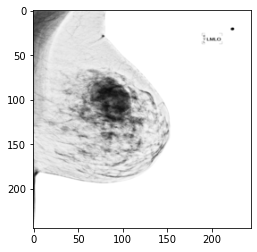

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Copie SVOB
SeriesDescription : R CC



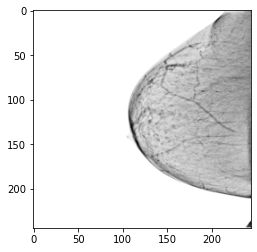

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie SVOB beiderzijds
SeriesDescription : L CC



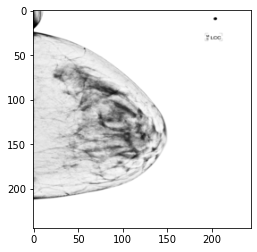

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie follow up bdz
SeriesDescription : R MLO



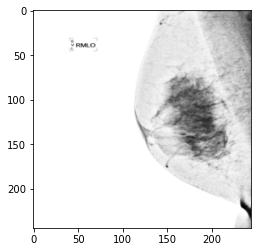

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie mammapoli beiderzijds
SeriesDescription : L LM



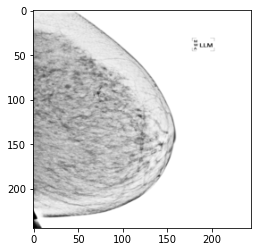

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie na lokalisatie rechts
SeriesDescription : R LM



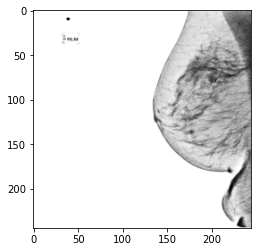

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Preparaat
SeriesDescription : R SPECIMEN



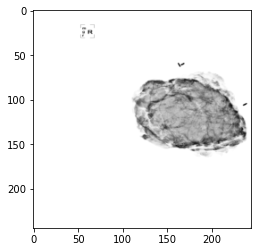

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Preparaat
SeriesDescription : L SPECIMEN



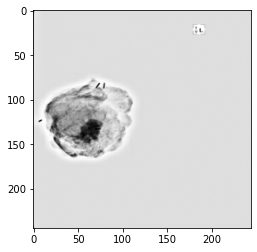

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie follow up links
SeriesDescription : L XCCL



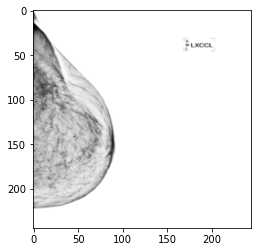

Modality        : MG
BodyPartExamined : BREAST
StudyDescription : Mammografie follow up bdz
SeriesDescription : R XCCL



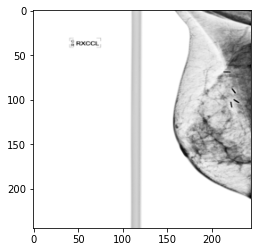

In [8]:
testset.plot_one_of_every('SeriesDescription')

True label: L MLO
Prediction : [('L SPECIMEN', 0.9757956862449646), ('L LM', 0.024163462221622467), ('R MLO', 1.9450710169621743e-05)]


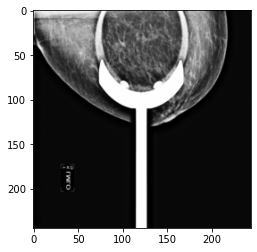

Overwrite class?no



True label: R MLO
Prediction : [('R CC', 0.9918261766433716), ('R MLO', 0.007319665513932705), ('R LM', 0.0007985678967088461)]


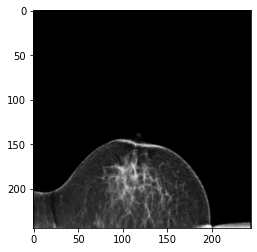

Overwrite class?no



True label: R XCCL
Prediction : [('R CC', 0.9999988079071045), ('L SPECIMEN', 1.1692305861288332e-06), ('R MLO', 3.240353763089843e-08)]


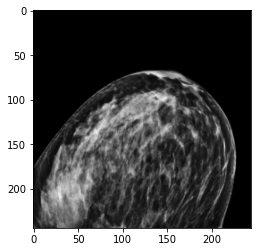

Overwrite class?no



True label: L XCCL
Prediction : [('L CC', 0.999980092048645), ('L XCCL', 1.0355843187426217e-05), ('L SPECIMEN', 9.161251909972634e-06)]


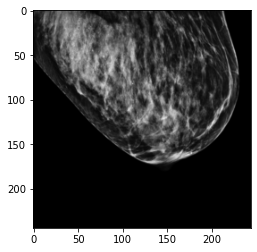

Overwrite class?no



True label: L CC
Prediction : [('L LM', 0.7731177806854248), ('L CC', 0.20369844138622284), ('L XCCL', 0.012223980389535427)]


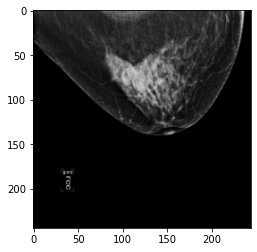

Overwrite class?no



True label: R XCCL
Prediction : [('R CC', 0.9999980926513672), ('R MLO', 1.074108467946644e-06), ('L SPECIMEN', 8.26732218683901e-07)]


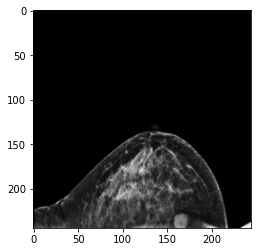

In [ ]:
correct_dataset(net2, testset)